In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import numpy as np
import cv2
from skimage.feature import hog
import pickle
import matplotlib.pyplot as plt
from google.colab import files


# Gán tên Sign


In [55]:
SIGN_NAMES = {
    0: "Gioi han toc do (20km/h)",
    1: "Gioi han toc do (30km/h)",
    2: "Gioi han toc do (50km/h)",
    3: "Gioi han toc do (60km/h)",
    4: "Gioi han toc do (70km/h)",
    5: "Gioi han toc do (100km/h)",
    6: "Het gioi han toc do (80km/h)",
    7: "Gioi han toc do (80km/h)",
    8: "Gioi han toc do (120km/h)",
    9: "Cam vuot",
    10: "Cam vuot (xe tren 3. 5 tan)",
    11: "Duong uu tien tai nga tu",
    12: "Duong uu tien",
    13: "Nhuong duong",
    14: "Dung lai (STOP)",
    15: "Cam phuong tien",
    16: "Cam xe tai (>3.5t)",
    17: "Cam di vao",
    18: "Canh bao nguy hiem chung",
    19: "Duong cong nguy hiem ben trai",
    20: "Duong cong nguy hiem ben phai",
    21: "Duong cong kep",
    22: "Duong go ghe",
    23: "Duong tron truot",
    24: "Duong hep ben phai",
    25: "Cong truong",
    26: "Den tin hieu giao thong",
    27: "Nguoi di bo",
    28: "Tre em qua duong",
    29: "Xe dap qua duong",
    30: "Can than bang/tuyet",
    31: "Dong vat hoang da",
    32: "Het tat ca gioi han",
    33: "Re phai phia truoc",
    34: "Re trai phia truoc",
    35: "Chi duoc di thang",
    36: "Di thang hoac re phai",
    37: "Di thang hoac re trai",
    38: "Di ben phai",
    39: "Di ben trai",
    40: "Vong xuyen bat buoc",
    41: "Het cam vuot",
    42: "Het cam vuot (xe >3.5t)"
}

In [56]:
MODEL_PATH = '/content/drive/MyDrive/Project/XLAS/'

print("📥 Loading model and scaler...")

model_files = ['svm_hog_classweight_model.pkl', 'svm_hog_license_plate_model.pkl']
svm_model = None
for mf in model_files:
    try:
        with open(MODEL_PATH + mf, 'rb') as f:
            svm_model = pickle.load(f)
        print(f"✅ Model: {mf}")
        break
    except:
        continue

scaler_files = ['hog_scaler.pkl', 'scaler.pkl', 'scaler_cw.pkl']
scaler = None
for sf in scaler_files:
    try:
        with open(MODEL_PATH + sf, 'rb') as f:
            scaler = pickle.load(f)
        print(f"✅ Scaler: {sf}")
        break
    except:
        continue

📥 Loading model and scaler...
✅ Model: svm_hog_classweight_model.pkl
✅ Scaler: hog_scaler.pkl


# Làm rõ ảnh


In [57]:
def enhance_image(image):
    """
    Tiền xử lý và làm rõ ảnh trước khi nhận diện
    """
    enhanced = image.copy()

    # 1. Phóng to ảnh nếu quá nhỏ (< 100px)
    h, w = enhanced.shape[:2]
    if h < 100 or w < 100:
        scale = max(100 / h, 100 / w)
        new_size = (int(w * scale), int(h * scale))
        enhanced = cv2. resize(enhanced, new_size, interpolation=cv2.INTER_CUBIC)
        print(f"   📐 Phong to: {w}x{h} -> {new_size[0]}x{new_size[1]}")

    # 2. Giảm nhiễu (Denoise)
    enhanced = cv2.fastNlMeansDenoisingColored(enhanced, None, 10, 10, 7, 21)

    # 3. Tăng độ tương phản (CLAHE)
    lab = cv2.cvtColor(enhanced, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)

    # 4. Tăng độ sắc nét (Sharpening)
    kernel_sharpen = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel_sharpen)

    # 5.  Tăng độ bão hòa màu
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    hsv[:, :, 1] = cv2.add(hsv[:, :, 1], 30)  # Tăng saturation
    hsv[:, :, 2] = cv2.add(hsv[:, :, 2], 10)  # Tăng brightness nhẹ
    enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return enhanced

In [58]:
def extract_hog(image, size=(32, 32)):
    img = cv2.resize(image, size)
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)
    return features


# Kiểm tra có phải biển báo không?


In [59]:
def is_valid_sign_roi(roi):
    """Kiểm tra ROI có phải biển báo thật không"""
    if roi.size == 0 or roi.shape[0] < 10 or roi.shape[1] < 10:
        return False

    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    total = roi.shape[0] * roi.shape[1]

    # Màu đỏ
    mask_red1 = cv2.inRange(hsv, np.array([0, 70, 50]), np.array([10, 255, 255]))
    mask_red2 = cv2.inRange(hsv, np.array([160, 70, 50]), np.array([180, 255, 255]))
    red_ratio = (np.sum(mask_red1 > 0) + np.sum(mask_red2 > 0)) / total

    # Màu trắng
    mask_white = cv2.inRange(hsv, np.array([0, 0, 150]), np.array([180, 60, 255]))
    white_ratio = np.sum(mask_white > 0) / total

    # Màu xanh dương
    mask_blue = cv2.inRange(hsv, np.array([100, 70, 50]), np.array([130, 255, 255]))
    blue_ratio = np.sum(mask_blue > 0) / total

    # Màu vàng
    mask_yellow = cv2.inRange(hsv, np.array([15, 70, 50]), np.array([35, 255, 255]))
    yellow_ratio = np.sum(mask_yellow > 0) / total

    # Biển báo cần có đủ màu đặc trưng
    is_valid = (red_ratio > 0.08 and white_ratio > 0.05) or \
               (blue_ratio > 0.15) or \
               (yellow_ratio > 0.10 and red_ratio > 0.05) or \
               (red_ratio > 0.20)

    return is_valid

In [60]:
def detect_multiple_signs(image):
    """
    Phát hiện TẤT CẢ biển báo trong ảnh
    Trả về danh sách bounding boxes
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, w = image.shape[:2]
    img_area = h * w

    # === MASK MÀU ĐỎ ===
    mask_red1 = cv2.inRange(hsv, np.array([0, 50, 50]), np.array([10, 255, 255]))
    mask_red2 = cv2.inRange(hsv, np.array([160, 50, 50]), np.array([180, 255, 255]))
    mask_red = cv2.add(mask_red1, mask_red2)

    # === MASK MÀU XANH DƯƠNG ===
    mask_blue = cv2.inRange(hsv, np.array([100, 50, 50]), np. array([130, 255, 255]))

    # === MASK MÀU VÀNG ===
    mask_yellow = cv2. inRange(hsv, np. array([15, 50, 50]), np.array([35, 255, 255]))

    # === MASK MÀU TRẮNG (nền biển) ===
    mask_white = cv2.inRange(hsv, np.array([0, 0, 180]), np.array([180, 30, 255]))

    # Kết hợp tất cả masks
    mask_combined = cv2.add(mask_red, mask_blue)
    mask_combined = cv2.add(mask_combined, mask_yellow)

    # Morphology để làm sạch và kết nối
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_combined = cv2.morphologyEx(mask_combined, cv2. MORPH_CLOSE, kernel, iterations=3)
    mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel, iterations=1)

    # Dilate để mở rộng vùng phát hiện
    mask_combined = cv2.dilate(mask_combined, kernel, iterations=2)

    # Tìm contours
    contours, _ = cv2.findContours(mask_combined, cv2.RETR_EXTERNAL, cv2. CHAIN_APPROX_SIMPLE)

    boxes = []

    for cnt in contours:
        area = cv2.contourArea(cnt)

        # Lọc diện tích: tối thiểu 0.5% ảnh, tối đa 50%
        if area < img_area * 0.005 or area > img_area * 0.5:
            continue

        x, y, bw, bh = cv2. boundingRect(cnt)

        # Lọc tỷ lệ
        aspect = bw / bh if bh > 0 else 0
        if aspect < 0.4 or aspect > 2.5:
            continue

        # Padding
        pad = int(min(bw, bh) * 0.15)
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(w, x + bw + pad)
        y2 = min(h, y + bh + pad)

        # Kiểm tra ROI có phải biển báo không
        roi = image[y1:y2, x1:x2]
        if is_valid_sign_roi(roi):
            boxes. append((x1, y1, x2 - x1, y2 - y1, area))

    # Sắp xếp theo diện tích giảm dần
    boxes.sort(key=lambda b: b[4], reverse=True)

    return [(x, y, w, h) for x, y, w, h, _ in boxes]


In [61]:
def is_single_sign_image(image):
    """
    Kiểm tra ảnh đã là biển báo chưa
    Hạ ngưỡng xuống để nhận diện tốt hơn với ảnh nhỏ/mờ
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    total_pixels = image.shape[0] * image. shape[1]

    # Mask màu ĐỎ (mở rộng ngưỡng)
    mask_red1 = cv2.inRange(hsv, np.array([0, 50, 50]), np.array([10, 255, 255]))
    mask_red2 = cv2.inRange(hsv, np.array([160, 50, 50]), np.array([180, 255, 255]))
    mask_red = cv2.add(mask_red1, mask_red2)

    # Mask màu TRẮNG
    mask_white = cv2. inRange(hsv, np. array([0, 0, 150]), np.array([180, 60, 255]))

    # Mask màu XANH DƯƠNG
    mask_blue = cv2.inRange(hsv, np.array([100, 50, 50]), np.array([130, 255, 255]))

    # Mask màu VÀNG
    mask_yellow = cv2.inRange(hsv, np.array([15, 50, 50]), np.array([35, 255, 255]))

    # Tính tỷ lệ
    red_ratio = np.sum(mask_red > 0) / total_pixels
    white_ratio = np.sum(mask_white > 0) / total_pixels
    blue_ratio = np.sum(mask_blue > 0) / total_pixels
    yellow_ratio = np.sum(mask_yellow > 0) / total_pixels

    total_sign_color = red_ratio + white_ratio + blue_ratio + yellow_ratio

    # ⭐ HẠ NGƯỠNG: Nếu > 20% màu biển báo hoặc ảnh nhỏ < 100px -> coi là biển báo
    h, w = image.shape[:2]
    is_small_image = (h < 100 or w < 100)

    is_sign = (total_sign_color > 0.35) or \
              (red_ratio > 0.15) or \
              (red_ratio + white_ratio > 0.25) or \
              (blue_ratio > 0.20) or \
              is_small_image  # Ảnh nhỏ -> coi là biển báo đơn lẻ

    return is_sign, {
        'red': red_ratio,
        'white': white_ratio,
        'blue': blue_ratio,
        'yellow': yellow_ratio,
        'total': total_sign_color
    }


In [62]:
def detect_signs_in_scene(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, w = image.shape[:2]
    img_area = h * w

    mask_red1 = cv2.inRange(hsv, np.array([0, 70, 50]), np.array([10, 255, 255]))
    mask_red2 = cv2. inRange(hsv, np. array([160, 70, 50]), np.array([180, 255, 255]))
    mask_red = mask_red1 + mask_red2

    mask_blue = cv2.inRange(hsv, np.array([100, 70, 50]), np.array([130, 255, 255]))
    mask_yellow = cv2.inRange(hsv, np.array([15, 70, 50]), np.array([35, 255, 255]))

    mask = mask_red + mask_blue + mask_yellow

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2. MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2. MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask, cv2. RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < img_area * 0.01:
            continue

        x, y, bw, bh = cv2.boundingRect(cnt)
        aspect = bw / bh if bh > 0 else 0

        if aspect < 0.4 or aspect > 2.5:
            continue

        pad = int(min(bw, bh) * 0.15)
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(w, x + bw + pad)
        y2 = min(h, y + bh + pad)

        boxes.append((x1, y1, x2 - x1, y2 - y1, area))

    boxes.sort(key=lambda b: b[4], reverse=True)
    return [(x, y, w, h) for x, y, w, h, _ in boxes]


# Loại bỏ box chồng chéo

In [63]:
def non_max_suppression(boxes, iou_threshold=0.3):
    if len(boxes) == 0:
        return []

    boxes_array = np.array([[x, y, x+w, y+h, w*h] for (x, y, w, h) in boxes], dtype=np.float32)
    idxs = np.argsort(boxes_array[:, 4])[::-1]

    selected = []
    while len(idxs) > 0:
        current = idxs[0]
        selected.append(current)

        if len(idxs) == 1:
            break

        remaining = idxs[1:]
        current_box = boxes_array[current]
        remaining_boxes = boxes_array[remaining]

        x1 = np.maximum(current_box[0], remaining_boxes[:, 0])
        y1 = np.maximum(current_box[1], remaining_boxes[:, 1])
        x2 = np.minimum(current_box[2], remaining_boxes[:, 2])
        y2 = np.minimum(current_box[3], remaining_boxes[:, 3])

        inter = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
        area1 = (current_box[2] - current_box[0]) * (current_box[3] - current_box[1])
        area2 = (remaining_boxes[:, 2] - remaining_boxes[:, 0]) * (remaining_boxes[:, 3] - remaining_boxes[:, 1])

        iou = inter / (area1 + area2 - inter + 1e-6)
        idxs = remaining[iou < iou_threshold]

    return [(int(boxes_array[i][0]), int(boxes_array[i][1]),
             int(boxes_array[i][2] - boxes_array[i][0]),
             int(boxes_array[i][3] - boxes_array[i][1])) for i in selected]


In [64]:
def predict_sign(roi, model, scaler):
    features = extract_hog(roi)
    features_scaled = scaler.transform(features. reshape(1, -1))
    pred = model.predict(features_scaled)
    return int(pred[0])

In [65]:
def detect_individual_signs(image):
    """
    Phát hiện TỪNG biển báo riêng biệt dựa trên:
    1. Phát hiện hình tròn (Hough Circles) - biển tròn
    2. Phát hiện đa giác (approxPolyDP) - biển tam giác, vuông
    3. Phân tích contours với điều kiện chặt hơn
    """
    h, w = image.shape[:2]
    img_area = h * w

    # Chuyển đổi màu
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    all_boxes = []

    # ========== PHƯƠNG PHÁP 1: HOUGH CIRCLES (biển tròn) ==========
    gray_blur = cv2.GaussianBlur(gray, (9, 9), 2)
    circles = cv2.HoughCircles(
        gray_blur,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=30,
        param1=50,
        param2=30,
        minRadius=15,
        maxRadius=min(h, w) // 3
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            cx, cy, r = circle
            # Tạo bounding box từ circle
            x1 = max(0, cx - r - 5)
            y1 = max(0, cy - r - 5)
            x2 = min(w, cx + r + 5)
            y2 = min(h, cy + r + 5)

            box_w = x2 - x1
            box_h = y2 - y1

            if box_w > 20 and box_h > 20:
                all_boxes.append({
                    'bbox': (x1, y1, box_w, box_h),
                    'area': box_w * box_h,
                    'type': 'circle',
                    'center': (cx, cy)
                })

    # ========== PHƯƠNG PHÁP 2: CONTOURS + HÌNH DẠNG ==========
    # Mask màu đỏ
    mask_red1 = cv2.inRange(hsv, np.array([0, 70, 70]), np.array([10, 255, 255]))
    mask_red2 = cv2.  inRange(hsv, np. array([160, 70, 70]), np.array([180, 255, 255]))
    mask_red = cv2.add(mask_red1, mask_red2)

    # Mask màu trắng (nền biển)
    mask_white = cv2.  inRange(hsv, np.  array([0, 0, 180]), np.array([180, 50, 255]))

    # Kết hợp đỏ và trắng
    mask_sign = cv2.add(mask_red, mask_white)

    # Morphology NHẸ để không gộp các biển lại
    kernel_small = np.ones((3, 3), np.uint8)
    mask_sign = cv2. morphologyEx(mask_sign, cv2.  MORPH_CLOSE, kernel_small, iterations=1)

    # Tìm contours
    contours, _ = cv2.findContours(mask_sign, cv2.  RETR_EXTERNAL, cv2. CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        area = cv2.contourArea(cnt)

        # Lọc diện tích
        if area < img_area * 0.003 or area > img_area * 0.25:
            continue

        # Xấp xỉ đa giác
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)

        x, y, bw, bh = cv2. boundingRect(cnt)
        aspect = bw / bh if bh > 0 else 0

        # Lọc tỷ lệ
        if aspect < 0.5 or aspect > 2.0:
            continue

        # Padding nhỏ
        pad = int(min(bw, bh) * 0.1)
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(w, x + bw + pad)
        y2 = min(h, y + bh + pad)

        # Xác định loại hình
        n_vertices = len(approx)
        if n_vertices == 3:
            shape_type = 'triangle'
        elif n_vertices == 4:
            shape_type = 'rectangle'
        elif n_vertices > 6:
            shape_type = 'circle'
        else:
            shape_type = 'polygon'

        all_boxes.append({
            'bbox': (x1, y1, x2 - x1, y2 - y1),
            'area': area,
            'type': shape_type,
            'center': (x + bw // 2, y + bh // 2)
        })

    # ========== PHƯƠNG PHÁP 3: Sliding window cho biển nhỏ ==========
    # Nếu ít box, thử chia nhỏ vùng chứa biển
    if len(all_boxes) < 3:
        # Tìm vùng chứa tất cả biển báo (vùng có nhiều màu đỏ)
        mask_red_dilated = cv2.dilate(mask_red, np.ones((10, 10), np.uint8), iterations=2)
        contours_large, _ = cv2.findContours(mask_red_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours_large:
            x, y, bw, bh = cv2.boundingRect(cnt)

            # Nếu vùng này lớn và dài (chứa nhiều biển xếp dọc/ngang)
            if bh > h * 0.4 or bw > w * 0.4:
                # Chia thành các phần nhỏ hơn
                roi = image[y:y+bh, x:x+bw]
                sub_boxes = detect_signs_in_roi(roi, x, y)
                all_boxes.extend(sub_boxes)

    return all_boxes

# MAIN

In [71]:
def recognize_traffic_signs(image_input):
    """Nhận diện TẤT CẢ biển báo trong ảnh"""

    if isinstance(image_input, str):
        image = cv2.imread(image_input)
    else:
        image = image_input. copy()

    if image is None:
        print("❌ Khong the doc anh!")
        return None

    h, w = image.shape[:2]
    print(f"\n📷 Kich thuoc: {w} x {h}")

    # Tiền xử lý
    print("🔧 Tien xu ly...")
    image_enhanced = enhance_image(image)

    # Phát hiện từng biển báo
    print("🔍 Phat hien tung bien bao...")
    all_boxes = detect_individual_signs(image_enhanced)
    print(f"   Raw: {len(all_boxes)} boxes")

    # NMS
    boxes = nms_boxes(all_boxes, iou_threshold=0.25)
    print(f"   After NMS: {len(boxes)} bien bao")

    results = []

    if len(boxes) == 0:
        print("⚠️ Khong phat hien -> Nhan dien toan bo")
        pred = predict_sign(image_enhanced, svm_model, scaler)
        results.append({
            'class': pred,
            'name': SIGN_NAMES. get(pred, f"Unknown ({pred})"),
            'roi': image_enhanced,
            'bbox': None
        })
    else:
        print(f"✅ Phat hien {len(boxes)} BIEN BAO!")

        image_display = image_enhanced.copy()
        colors = [(0,255,0), (255,0,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255)]

        for i, box_info in enumerate(boxes):
            x, y, bw, bh = box_info['bbox']
            x, y, bw, bh = int(x), int(y), int(bw), int(bh)

            roi = image_enhanced[y:y+bh, x:x+bw]
            if roi.size == 0:
                continue

            pred = predict_sign(roi, svm_model, scaler)
            name = SIGN_NAMES.get(pred, f"Unknown ({pred})")

            results.append({
                'class': pred,
                'name': name,
                'roi': roi,
                'bbox': (x, y, bw, bh)
            })

            color = colors[i % len(colors)]
            cv2.rectangle(image_display, (x, y), (x+bw, y+bh), color, 3)
            cv2.putText(image_display, f"#{i+1}", (x+5, y+25),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # Hiển thị
    n = len(results)
    if n > 0:
        fig = plt.figure(figsize=(5 * min(n+1, 5), 5))

        ax0 = fig.add_subplot(1, min(n+1, 5), 1)
        ax0. imshow(cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB))
        ax0. set_title(f"Phat hien {n} bien bao", fontsize=11, fontweight='bold')
        ax0.axis('off')

        for i, res in enumerate(results[:4]):
            ax = fig.add_subplot(1, min(n+1, 5), i+2)
            ax.imshow(cv2.cvtColor(res['roi'], cv2.COLOR_BGR2RGB))
            ax.set_title(f"#{i+1} Class {res['class']}\n{res['name'][:20]}", fontsize=9)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    # In kết quả
    print("\n" + "="*50)
    print(f"📋 KET QUA: {len(results)} BIEN BAO")
    print("="*50)
    for i, res in enumerate(results):
        print(f"\n🚦 #{i+1}: Class {res['class']} - {res['name']}")

    return results


📤 UPLOAD ANH DE NHAN DIEN


Saving z7290253608214_369a430eb7c32cc8de1f0e813ef9e409.jpg to z7290253608214_369a430eb7c32cc8de1f0e813ef9e409 (4).jpg

📷 File: z7290253608214_369a430eb7c32cc8de1f0e813ef9e409 (4).jpg

📷 Kich thuoc anh goc: 390 x 280
🔧 Dang tien xu ly anh (lam ro, tang cuong)...
   Kich thuoc sau xu ly: 390 x 280
📊 Ty le mau (sau enhance): Red=6.2%, White=34.0%, Blue=15.6%, Yellow=15.1%
✅ Anh da la bien bao -> Nhan dien truc tiep


/tmp/ipython-input-3193173442.py:59: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


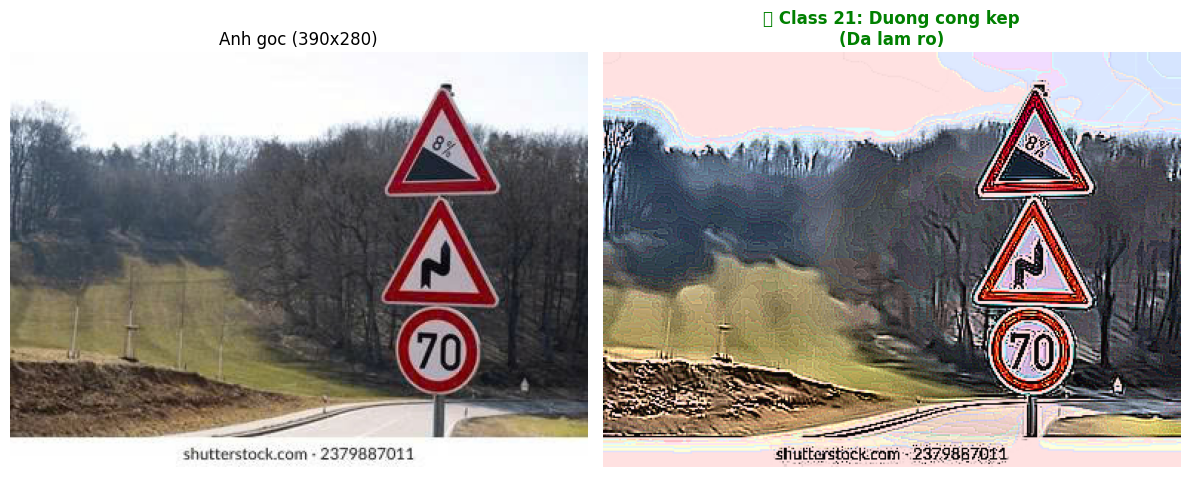


KET QUA NHAN DIEN

🚦 Bien bao #1:
   Class ID: 21
   Ten: Duong cong kep


In [74]:
print("\n" + "=" * 60)
print("📤 UPLOAD ANH DE NHAN DIEN")
print("=" * 60)

uploaded = files.upload()

for filename in uploaded. keys():
    print(f"\n{'=' * 60}")
    print(f"📷 File: {filename}")
    print(f"{'=' * 60}")

    nparr = np.frombuffer(uploaded[filename], np.uint8)
    image = cv2.imdecode(nparr, cv2. IMREAD_COLOR)

    results = recognize_traffic_sign(image)
